In [1]:
import numpy as np
import h5py
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.preprocessing
scaler = sklearn.preprocessing.StandardScaler();
import skimage
import skimage.filters
import skimage.morphology

import umap
import leidenalg
import scprep
import graphtools as gt

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import magic

In [2]:
#initialize a reader for the file
dataDir = Path(os.getcwd()) / 'denoised_data' 
filenames = ['210827_histories_nomedfilt.h5','220928_histories_nomedfilt.h5'] 

f = {};
for fname in filenames :
    f[fname[0:-3]] = h5py.File(dataDir / fname, 'r')
    
dsetlabels = list(f.keys());
# print(dsetlabels)

In [3]:
#list the variables in a file
dsetlabel = list(f.keys())[0]
keylist = list(f[dsetlabel].keys())
print(keylist)

# NCratio: nuclear to cytoplasmic SMAD4 over time
# cytLevel : cytoplasmic level of SMAD4 over time
# nucLevel : cytoplasmic level of SMAD4 over time
# For nucLevel, cytLevel, and NCratio, the first dimension is the channel, and the first channel is h2b while the second is smad4
Smad4channel = 1;

# nucArea, nucMajorAxis, nucMinorAxis: nuclear area, major and minor axis over time
# XY, nucZ: xy and z coordinates of nuclei over time
# conditions: description of experimental conditions used
# positionIdx: index to conditions for each signaling history 
# fixedChannels: description of stains after fixation
# liveChannels: channels in the live data
# tvec: vector of timepoints in hrs relative to BMP treatment

['NCratio', 'XY', 'cA', 'cB', 'cU', 'cV', 'conditions', 'cr', 'cytLevel', 'fateMarkers', 'fixedChannels', 'liveChannels', 'normalizedChannels', 'normalizedMarkers', 'nucArea', 'nucLevel', 'nucMajorAxis', 'nucMinorAxis', 'nucZ', 'positionIdx', 'tvec', 'vr']


In [4]:
# test reading the parts of the h5 files 
dsetlabel = list(f.keys())[0]
keylist = list(f[dsetlabel].keys())
print(keylist)
fixedChannels = [str(f[dsetlabel]['fixedChannels'][i][0])[2:-1] for i in range(0, len(f[dsetlabel]['fixedChannels']))]
print(fixedChannels)

['NCratio', 'XY', 'cA', 'cB', 'cU', 'cV', 'conditions', 'cr', 'cytLevel', 'fateMarkers', 'fixedChannels', 'liveChannels', 'normalizedChannels', 'normalizedMarkers', 'nucArea', 'nucLevel', 'nucMajorAxis', 'nucMinorAxis', 'nucZ', 'positionIdx', 'tvec', 'vr']
['DAPI', 'ISL1', 'SOX2', 'NANOG']


In [5]:
# convert into numpy arrays and print size and shape
dset = {};
for dsetlabel in f.keys():

    dset[dsetlabel] = {};
    keylist = list(f[dsetlabel].keys())
    for key in keylist:
        dset[dsetlabel][key] = np.squeeze(np.array(f[dsetlabel][key]))

    print(dsetlabel + ', ' + keylist[0])
    print(dset[dsetlabel][keylist[0]].shape)

210827_histories_nomedfilt, NCratio
(2, 703, 254)
220928_histories_nomedfilt, NCratio
(2, 369, 256)


In [6]:
# show fate markers for each dataset
for dsetlabel in f.keys():
    
    fixedChannels = [str(f[dsetlabel]['fixedChannels'][i][0])[2:-1] for i in range(0, len(f[dsetlabel]['fixedChannels']))];
    print(dsetlabel)
    #print(fixedChannels)
    print([g for g in fixedChannels if g!='DAPI' and g!='pSmad1'])

# for 220928, select the higher quality stains out of repeated stains
dsetlabel = '220928_histories_nomedfilt';    
fixedChannels = [str(f[dsetlabel]['fixedChannels'][i][0])[2:-1] for i in range(0, len(f[dsetlabel]['fixedChannels']))];
fmidx = [1,2,3, 5,6,7, 9];
actualfmChannels = [fixedChannels[i] for i in fmidx];
print(actualfmChannels)

210827_histories_nomedfilt
['ISL1', 'SOX2', 'NANOG']
220928_histories_nomedfilt
['ISL1', 'SOX2', 'NANOG', 'OCT4', 'TFAP2C', 'HAND1', 'GATA3', 'TFAP2C', 'GATA3']
['ISL1', 'SOX2', 'NANOG', 'OCT4', 'TFAP2C', 'HAND1', 'GATA3']


## Load signaling histories and fate markers

In [7]:
# reorganize into dictionaries for each variable indexed by dataset

chist = {}; # clean histories
conditionIdx = {};
fateMarkers = {};
channelLabels = {};
t = {};

for dsetlabel in f.keys():
    
    print(dsetlabel)
    
    chist[dsetlabel] = dset[dsetlabel]['NCratio'][Smad4channel];
    conditionIdx[dsetlabel] = dset[dsetlabel]['positionIdx'];
    fateMarkers[dsetlabel] = dset[dsetlabel]['fateMarkers'];
    channelLabels[dsetlabel] = [str(f[dsetlabel]['fixedChannels'][i][0])[2:-1] for i in range(0, len(f[dsetlabel]['fixedChannels']))];
    
    t[dsetlabel] = dset[dsetlabel]['tvec'].transpose();

210827_histories_nomedfilt
220928_histories_nomedfilt


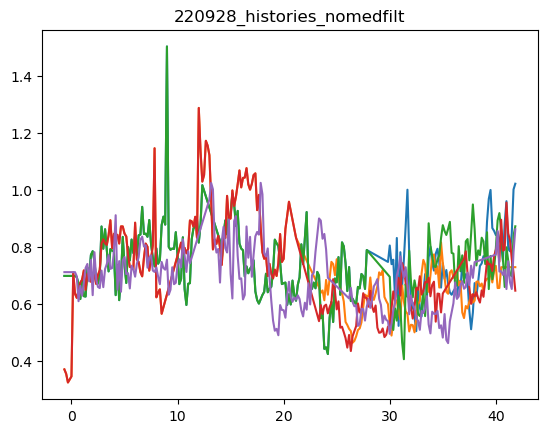

In [8]:
# plot some example histories

i = 0;
d = list(f.keys())[1]
plt.plot(t[d],chist[d][i:i+5,:].transpose());
plt.title(d);

## Dimensional reduction and clustering of fate markers

In [9]:
# for 220928 data, used for first part of figure 3
# see how well a UMAP based on the fate markers separates the fates

dsetlabel = '220928_histories_nomedfilt';
fm = pd.DataFrame(dset[dsetlabel]['fateMarkers'][:,fmidx],columns = actualfmChannels)
# log transform and scale
fm = pd.DataFrame(scaler.fit_transform(np.log(fm)),columns = actualfmChannels)

In [10]:
# UMAP
fm_umap = umap.UMAP(min_dist=0.2, n_neighbors=10).fit_transform(fm)

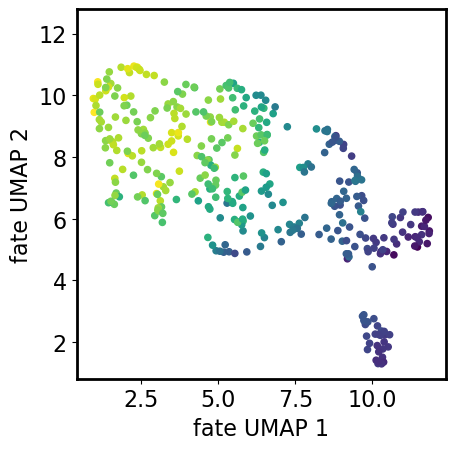

In [11]:
# visualize UMAP
# colored for log(ISL1/NANOG)

plt.rcParams.update({'font.size':16})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

plt.scatter(fm_umap[:,0],fm_umap[:,1],s=20,c=fm['ISL1']-fm['NANOG'])
plt.axis('square');
#plt.legend(handles=scatter.legend_elements()[0],labels=labelnames,loc="upper right", title="Classes");
plt.xlabel('fate UMAP 1');
plt.ylabel('fate UMAP 2');

#plt.savefig('multiplexIFumapISL1NANOG.png')

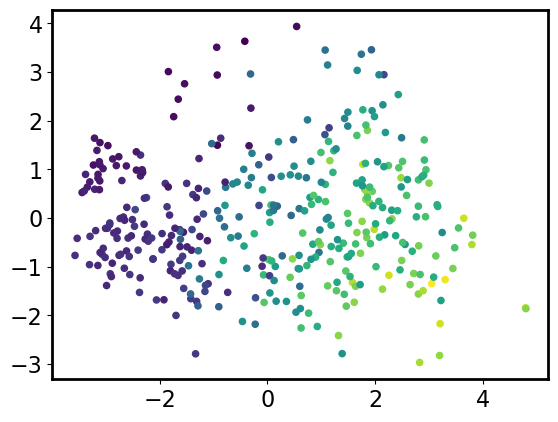

In [12]:
# principal component decomposition of fate, colored for log(ISL1)

PC = sklearn.decomposition.PCA(n_components=7).fit(fm);
pc = PC.transform(fm);
plt.scatter(pc[:,0],pc[:,1],s=20,c=fm['ISL1']);

(-1.7145699737777385,
 2.605331938854368,
 -1.485441664159814,
 2.8344602484722925)

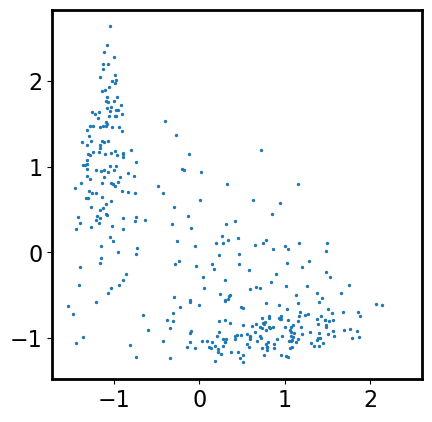

In [13]:
# log(ISL1) vs. log(NANOG) directly

plt.scatter(fm['ISL1'],fm['NANOG'],s=2); # ,c=fm_220928['SOX2']
plt.axis('square')

In [14]:
# clustering using Leiden
data_pca = scprep.reduce.pca(fm, n_components=7, method='dense')    
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()
partition = leidenalg.find_partition(G_igraph, leidenalg.RBConfigurationVertexPartition, 
                                   weights="weight", resolution_parameter=0.08) # improved clustering resolution doesn't improve PGC correlation
clusters = np.array(partition.membership)

# number of clusters
len(np.unique(clusters))

2

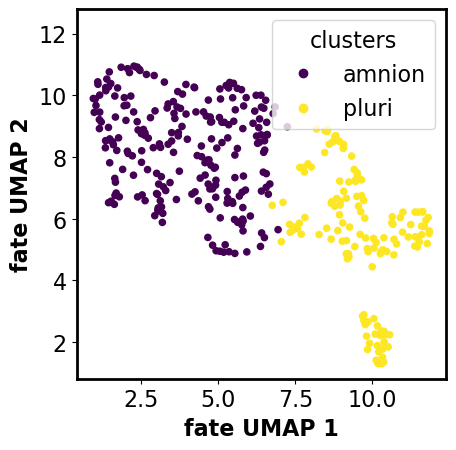

In [15]:
# show Leiden clustering on UMAP

plt.rcParams.update({'font.size':16})
plt.rcParams.update({'font.weight':'regular'})
plt.rcParams.update({'axes.linewidth': 2})

scatter = plt.scatter(fm_umap[:,0],fm_umap[:,1],s=20,c=clusters)
plt.axis('square');
plt.legend(handles=[scatter.legend_elements()[0][0],scatter.legend_elements()[0][len(scatter.legend_elements()[0])-1]],labels=['amnion','pluri'],loc="upper right", title="clusters");
plt.xlabel('fate UMAP 1', fontdict=dict(weight='bold'));
plt.ylabel('fate UMAP 2', fontdict=dict(weight='bold'));
#plt.title('Leiden clusters of IF');

#plt.savefig(dataDir / 'multiplexIFumapClusters.png',bbox_inches='tight')

In [16]:
# rank fate markers by differential expression between Leiden clusters

mean_diff_results = scprep.stats.differential_expression_by_cluster(fm, clusters, n_jobs=-1, direction='up',measure='ttest')
mean_diff_results[0]

ttest  rank
ISL1    26.379291     0
HAND1   13.760672     1
GATA3   10.597762     2
TFAP2C   7.473666     3
SOX2   -21.598826     4
OCT4   -24.290257     5
NANOG  -30.425794     6

In [17]:
# Gaussian Mixture Model results (from matlab) for display in same layout

pd.DataFrame(index=['ISL1/NANOG','ISL1','NANOG','OCT4','TFAP2C','SOX2','GATA3','HAND1'], columns=['cluster separation'], data=[2.2953,1.7382,1.3276,1.0131,0.91178,0.87805,0.76514,0.74409])

cluster separation
ISL1/NANOG             2.29530
ISL1                   1.73820
NANOG                  1.32760
OCT4                   1.01310
TFAP2C                 0.91178
SOX2                   0.87805
GATA3                  0.76514
HAND1                  0.74409

## Threshold ISL1/NANOG distributions and calculate average signaling history for each fate

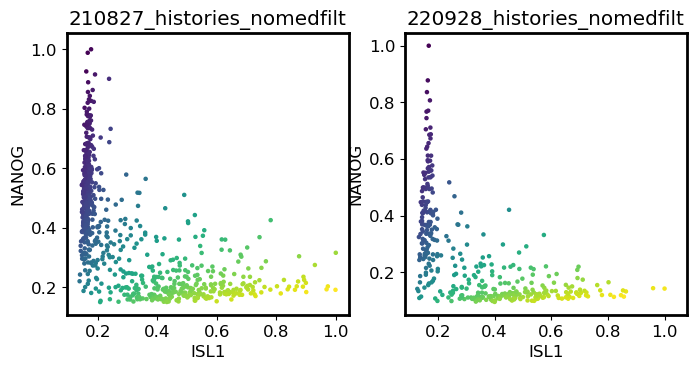

In [18]:
# scatterplot fate markers and color by logratio
Nrow=1; Ncol=len(dsetlabels);
plt.rcParams.update({'font.size':12})
fig, axes = plt.subplots(Nrow,Ncol, figsize=(Ncol*4,Nrow*4))
ax = axes.flatten()

# indices for ISL1 and NANOG
xi = 1; yi = 3;

logratio = {}

for i in range(len(dsetlabels)):

    d = dsetlabels[i]
    logratiolabel = 'log('+channelLabels[d][xi]+'/'+channelLabels[d][yi]+')';


    # # if using normalized (already log transformed) data:
    x = fateMarkers[d][:,xi]
    y = fateMarkers[d][:,yi]
    # logratio[d] = x-y; 
    # if not using normalized log transformed data:
    logratio[d] = np.log(x/y);

    scatter = ax[i].scatter(x/np.max(x),y/np.max(y),c=logratio[d],s=5);
    ax[i].axis('square');
    #plt.legend(handles=scatter.legend_elements()[0],labels=labelnames,loc="upper right", title="Classes");
    ax[i].set_xlabel(channelLabels[d][xi]);
    ax[i].set_ylabel(channelLabels[d][yi]);
    ax[i].set_title(d)

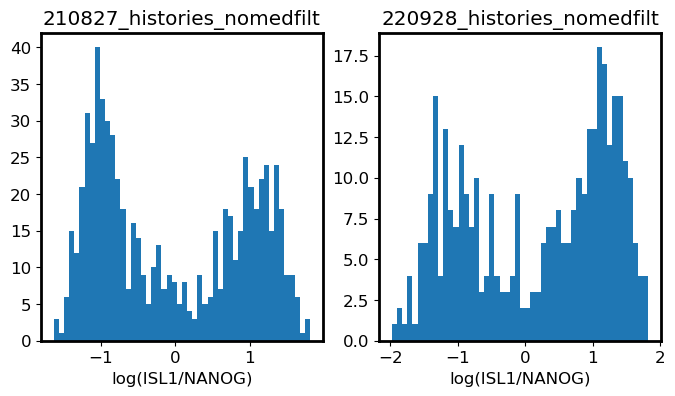

In [19]:
# distribution of log(ISL1/NANOG)

Nrow=1; Ncol=len(dsetlabels);
plt.rcParams.update({'font.size':12})
fig, axes = plt.subplots(Nrow,Ncol, figsize=(Ncol*4,Nrow*4))
ax = axes.flatten()

for i in range(len(dsetlabels)):

    d = dsetlabels[i]
    
    ax[i].hist(logratio[d],bins=50);
    ax[i].set_xlabel(logratiolabel);
    ax[i].set_title(d)

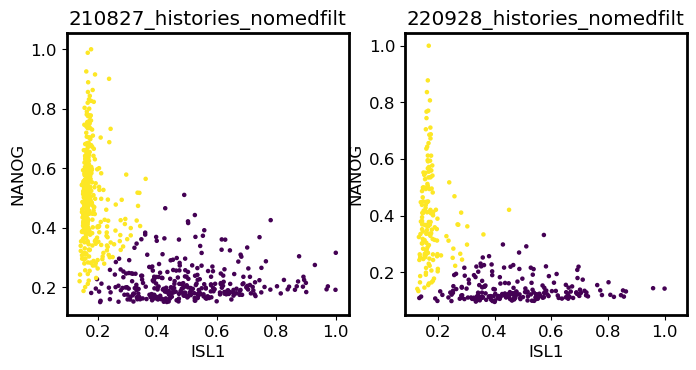

In [20]:
# scatterplot fate markers and color by class with possible margin (fmarg)

Nrow=1; Ncol=len(dsetlabels);
fig, axes = plt.subplots(Nrow,Ncol, figsize=(Ncol*4,Nrow*4))
ax = axes.flatten()

for i in range(len(dsetlabels)):

    d = dsetlabels[i]
    logratiolabel = 'log('+channelLabels[d][xi]+'/'+channelLabels[d][yi]+')';


    # # if using normalized (already log transformed) data:
    x = fateMarkers[d][:,xi]
    y = fateMarkers[d][:,yi]

    fmarg = 0;
    fatelabels = (logratio[d] > fmarg) + 2*(logratio[d] < -fmarg);
    
    scatter = ax[i].scatter(x/np.max(x),y/np.max(y),c=fatelabels,s=5);
    ax[i].axis('square');
    #plt.legend(handles=scatter.legend_elements()[0],labels=labelnames,loc="upper right", title="Classes");
    ax[i].set_xlabel(channelLabels[d][xi]);
    ax[i].set_ylabel(channelLabels[d][yi]);
    ax[i].set_title(d)

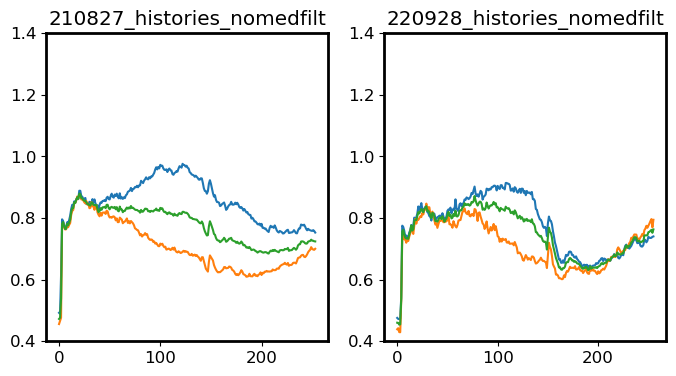

In [21]:
# threshold fate and plot mean history overall and per fate

# thresholds on log(ISL1/NANOG) for each dataset
rthresh = [0,0];

Nrow=1; Ncol=len(dsetlabels);
fig, axes = plt.subplots(Nrow,Ncol, figsize=(Ncol*4,Nrow*4))
ax = axes.flatten()

for i in range(len(dsetlabels)):

    d = dsetlabels[i]

    meanhist = np.mean(chist[d],axis=0)
    posmean = np.mean(chist[d][logratio[d] > rthresh[i],:],axis=0)
    negmean = np.mean(chist[d][logratio[d] < rthresh[i],:],axis=0)
    ax[i].plot(posmean)
    ax[i].plot(negmean)
    ax[i].plot(meanhist)
    ax[i].set_title(d)
    ax[i].set_ylim([0.4, 1.4])

## Train neural networs to predict fate from signaling history with PyTorch

In [101]:
# much code borrowed from Krishnaswamy lab workshop
# 210827 data, used for second part of figure 3

In [142]:
# define fates by thresholding log(ISL1/NANOG)
dsetlabel = '210827_histories_nomedfilt';
fmarg = 0;
fatelabels = (logratio[dsetlabel] > fmarg) + 2*(logratio[dsetlabel] < -fmarg); # 1 = amnion , 2 = pluri
binarylabels = fatelabels[fatelabels>0]==1;
histories = chist[dsetlabel][fatelabels > 0];

In [147]:
# split data into training and testing sets
data_training, data_validation, labels_training, labels_validation = train_test_split(histories, binarylabels, test_size=0.2)
data_training.shape

(562, 254)

In [148]:
# percentage we would get right by simply always guessing to most prevalent label
if np.sum(fatelabels[fatelabels>0]==1) > np.sum(fatelabels[fatelabels>0]==2):
    print(np.sum(labels_validation == 1)/len(labels_validation))
    print(np.sum(labels_training == 1)/len(labels_training))
else:
    print(np.sum(labels_validation == 0)/len(labels_validation))
    print(np.sum(labels_training == 0)/len(labels_training))

0.5602836879432624
0.5427046263345195


In [149]:
# create tensors for pytorch
train_tensor = torch.from_numpy(data_training).float()
train_labels_tensor = torch.from_numpy(labels_training).long()

valid_tensor = torch.from_numpy(data_validation).float()
valid_labels_tensor = torch.from_numpy(labels_validation).long()

data_tensor = torch.from_numpy(histories).float()
labels_tensor = torch.from_numpy(binarylabels).long()

In [164]:
# define neural networks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

ntime = len(t[dsetlabel])
inputsize = ntime;
nhidden = 20;
nclasses = 2;

# single layer neural network with sigmoid activation
class NeuralNetworkSimple(nn.Module):
    def __init__(self):
        super(NeuralNetworkSimple, self).__init__()
        
        self.layer = nn.Linear(inputsize, nclasses);
        self.activation = nn.Sigmoid()   
        nn.init.zeros_(self.layer.weight)
        nn.init.zeros_(self.layer.bias)

    def forward(self, x):
        logits = self.activation(self.layer(x))
        return logits
    
# add hidden layer
class NeuralNetworkHidden(nn.Module):
    def __init__(self):
        super(NeuralNetworkHidden, self).__init__()
        
        self.hiddenlayer = nn.Linear(inputsize, nhidden);
        self.outputlayer = nn.Linear(nhidden, 2);
        self.activation = nn.Sigmoid()
        
        nn.init.zeros_(self.hiddenlayer.weight)
        nn.init.zeros_(self.hiddenlayer.bias)
        
        nn.init.zeros_(self.outputlayer.weight)
        nn.init.zeros_(self.outputlayer.bias)

    def forward(self, x):
        y = self.activation(self.hiddenlayer(x))
        z = self.activation(self.outputlayer(y))
        return z

Using cpu device


In [165]:
# define training function

def simple_train(train_tensor, train_labels, model, N, lr):
    
    for i in range(0,N): 
        
        loss_fn = nn.MSELoss() # mean squared error (squared L2 norm) between each element in the input xxx and target yyy.
        optimizer = torch.optim.SGD(model.parameters(), momentum=0, lr=lr) # stochastic gradient descent (optionally with momentum)

        # Compute prediction error
        output = model(train_tensor);
        prob = output.softmax(1);
        pred = output.argmax(1).numpy();
        
        #loss = loss_fn(prob, train_labels_one_hot)
        loss = loss_fn(output,train_labels_one_hot)

        # Backpropagation
        loss.backward() # backpropagate the loss
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
        if i % 4000 == 0:

            print(str(i) + ' loss:' + ' ' + str(loss))
                
            output = model(train_tensor)
            train_prediction = output.argmax(1).numpy()
            acc_training = np.mean(train_prediction == train_labels_tensor.numpy())
            
            output = model(valid_tensor)
            valid_prediction = output.argmax(1).numpy()
            acc_valid = np.mean(valid_prediction == valid_labels_tensor.numpy())

            print('Training accuracy {:.3f}, validation accuracy {:.3f}'.format(acc_training, acc_valid))

In [166]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [169]:
# train and evaluate result using 5-fold cross-validation

# https://machinelearningmastery.com/k-fold-cross-validation/
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

n_splits = 5;
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
conf_matrix = np.zeros((2,2,n_splits)); 

label_prediction_all_NNS = np.nan*np.zeros(np.size(binarylabels));

N = 50000;
lr = 1e-1;

for i, (train_idx, test_idx) in enumerate(kfold.split(histories)):
    
    modelSimple = NeuralNetworkSimple().to(device)
    print(modelSimple) 

    data_training = histories[train_idx,:];
    labels_training = binarylabels[train_idx];
    
    data_validation = histories[test_idx,:];
    labels_validation = binarylabels[test_idx];
    
    train_tensor = torch.from_numpy(data_training).float()
    train_labels_tensor = torch.from_numpy(labels_training).long()
    # convert our integer class labels to a binary "one-hot" matrix
    train_labels_one_hot = to_one_hot(train_labels_tensor, nclasses)

    valid_tensor = torch.from_numpy(data_validation).float()
    valid_labels_tensor = torch.from_numpy(labels_validation).long()

    simple_train(train_tensor, train_labels_one_hot, modelSimple, N, lr)

    pred_all = modelSimple(data_tensor).argmax(1).numpy();
    pred_validation = modelSimple(valid_tensor).argmax(1).numpy();
    
    label_prediction_all_NNS[test_idx] = pred_validation;

    C = confusion_matrix(valid_labels_tensor.numpy(), pred_validation);
    conf_matrix[:,:,i] = C/np.sum(C);
    
# BEWARE: 0 is negative, 1 is positive so true positives are in element 1,1 true negatives in 0,0, false negative 1,0, false positive 0,1 - and positive corresponds to amnion here
conf_matrix = np.mean(conf_matrix,2);
# swap it around to match our convention in the paper
our_conf_matrix = np.array([[conf_matrix[1,0], conf_matrix[1,1]], [conf_matrix[0,0], conf_matrix[0,1]]]);

NeuralNetworkSimple(
  (layer): Linear(in_features=254, out_features=2, bias=True)
  (activation): Sigmoid()
)
0 loss: tensor(0.2500, grad_fn=<MseLossBackward0>)
Training accuracy 0.683, validation accuracy 0.709
4000 loss: tensor(0.1196, grad_fn=<MseLossBackward0>)
Training accuracy 0.835, validation accuracy 0.816
8000 loss: tensor(0.1076, grad_fn=<MseLossBackward0>)
Training accuracy 0.852, validation accuracy 0.844
12000 loss: tensor(0.0993, grad_fn=<MseLossBackward0>)
Training accuracy 0.879, validation accuracy 0.837
16000 loss: tensor(0.0931, grad_fn=<MseLossBackward0>)
Training accuracy 0.891, validation accuracy 0.837
20000 loss: tensor(0.0883, grad_fn=<MseLossBackward0>)
Training accuracy 0.900, validation accuracy 0.837
24000 loss: tensor(0.0843, grad_fn=<MseLossBackward0>)
Training accuracy 0.907, validation accuracy 0.830
28000 loss: tensor(0.0810, grad_fn=<MseLossBackward0>)
Training accuracy 0.907, validation accuracy 0.830
32000 loss: tensor(0.0781, grad_fn=<MseLossBack

In [617]:
print(dsetlabel)
print('confusion matrix: ',conf_matrix)
print('accuracy: ',conf_matrix[0,0]+conf_matrix[1,1])
# our matrix is permuted to match the integral thresholding in Fig. 4:
print('our confusion matrix: ',our_conf_matrix) 

210827_histories_nomedfilt
confusion matrix:  [[0.45943262 0.08676798]
 [0.08253293 0.37126646]]
accuracy:  0.8306990881458967
our confusion matrix:  [[0.08253293 0.37126646]
 [0.45943262 0.08676798]]


## SVM histories with cross-validation

In [175]:
from sklearn import svm

n_splits = 5;
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
conf_matrix = np.zeros((2,2,n_splits));

label_prediction_all_SVM = np.nan*np.zeros(np.size(binarylabels));

for i, (train_idx, test_idx) in enumerate(kfold.split(histories)):
    
    data_training = histories[train_idx,:];
    labels_training = binarylabels[train_idx];
    
    data_validation = histories[test_idx,:];
    labels_validation = binarylabels[test_idx];
    
    # create svm classifier
    model = svm.SVC(kernel='poly', degree=2) 
    model.fit(data_training, labels_training)
    labels_prediction = model.predict(data_validation)
    label_prediction_all_SVM[test_idx] = labels_prediction;
    C = confusion_matrix(labels_validation, labels_prediction);
    conf_matrix[:,:,i] = C/np.sum(C);

# BEWARE: 0 is negative, 1 is positive so true positives are in element 1,1 true negatives in 0,0, false negative 1,0, false positive 0,1 - and positive corresponds to amnion here
conf_matrix = np.mean(conf_matrix,2);
# swap it around to match our convention in the paper
our_conf_matrix = np.array([[conf_matrix[1,0], conf_matrix[1,1]], [conf_matrix[0,0], conf_matrix[0,1]]]);

# class balance
conf_matrix_cb = np.copy(conf_matrix); 
conf_matrix_cb[0,:] = conf_matrix[0,:]/(2*np.sum(conf_matrix[0,:]))
conf_matrix_cb[1,:] = conf_matrix[1,:]/(2*np.sum(conf_matrix[1,:]))

print(dsetlabel)
print('confusion matrix: ',conf_matrix)
print('class balanced confusion matrix: ',conf_matrix_cb)
print('accuracy: ',conf_matrix[0,0]+conf_matrix[1,1])
print('class balanced accuracy: ',conf_matrix_cb[0,0]+conf_matrix_cb[1,1])
print('our confusion matrix: ',our_conf_matrix)

210827_histories_nomedfilt
confusion matrix:  [[0.46084093 0.08535968]
 [0.08822695 0.36557244]]
class balanced confusion matrix:  [[0.42186051 0.07813949]
 [0.0972092  0.4027908 ]]
accuracy:  0.8264133738601824
class balanced accuracy:  0.8246513097726943
our confusion matrix:  [[0.08822695 0.36557244]
 [0.46084093 0.08535968]]


## Denoise histories using MAGIC

Calculating MAGIC...
  Running MAGIC on 703 cells and 254 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Calculating KNN search...
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating imputation...
Calculated MAGIC in 0.05 seconds.


/Users/idse/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 120 and 123, 696 and 697. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


Running MAGIC on 703 cells and 257 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.01 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
Calculated graph and diffusion operator in 0.04 seconds.
Calculating imputation...
Running MAGIC on 703 cells and 254 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.01 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
Calculated graph and diffusion operator in 0.04 seconds.
Calculating imputation...
Calculating imputation...


/Users/idse/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 120 and 123, 696 and 697. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/idse/.local/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Running MAGIC on 703 cells and 3 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Calculated graph and diffusion operator in 0.01 seconds.
Calculating imputation...
Calculating imputation...


/Users/idse/.local/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculating MAGIC...
  Running MAGIC on 703 cells and 257 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating imputation...
Calculated MAGIC in 0.07 seconds.
Calculating MAGIC...
  Running MAGIC on 369 cells and 256 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating imputation...
Calculated MAGIC in 0.03 seconds.


/Users/idse/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 19 and 20, 52 and 59, 80 and 81, 86 and 91. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


Running MAGIC on 369 cells and 263 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.01 seconds.
  Calculating KNN search...
  Calculating affinities...
Calculated graph and diffusion operator in 0.03 seconds.
Calculating imputation...
Running MAGIC on 369 cells and 256 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculating KNN search...
  Calculating affinities...
Calculated graph and diffusion operator in 0.02 seconds.
Calculating imputation...
Calculating imputation...


/Users/idse/opt/anaconda3/envs/Mplex_analysis/lib/python3.8/site-packages/graphtools/graphs.py:280: RuntimeWarning: Detected zero distance between samples 19 and 20, 52 and 59, 80 and 81, 86 and 91. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/idse/.local/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Running MAGIC on 369 cells and 7 genes.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Calculating imputation...
Calculating imputation...
Calculating MAGIC...
  Running MAGIC on 369 cells and 263 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating imputation...
Calculated MAGIC in 0.04 seconds.


/Users/idse/.local/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


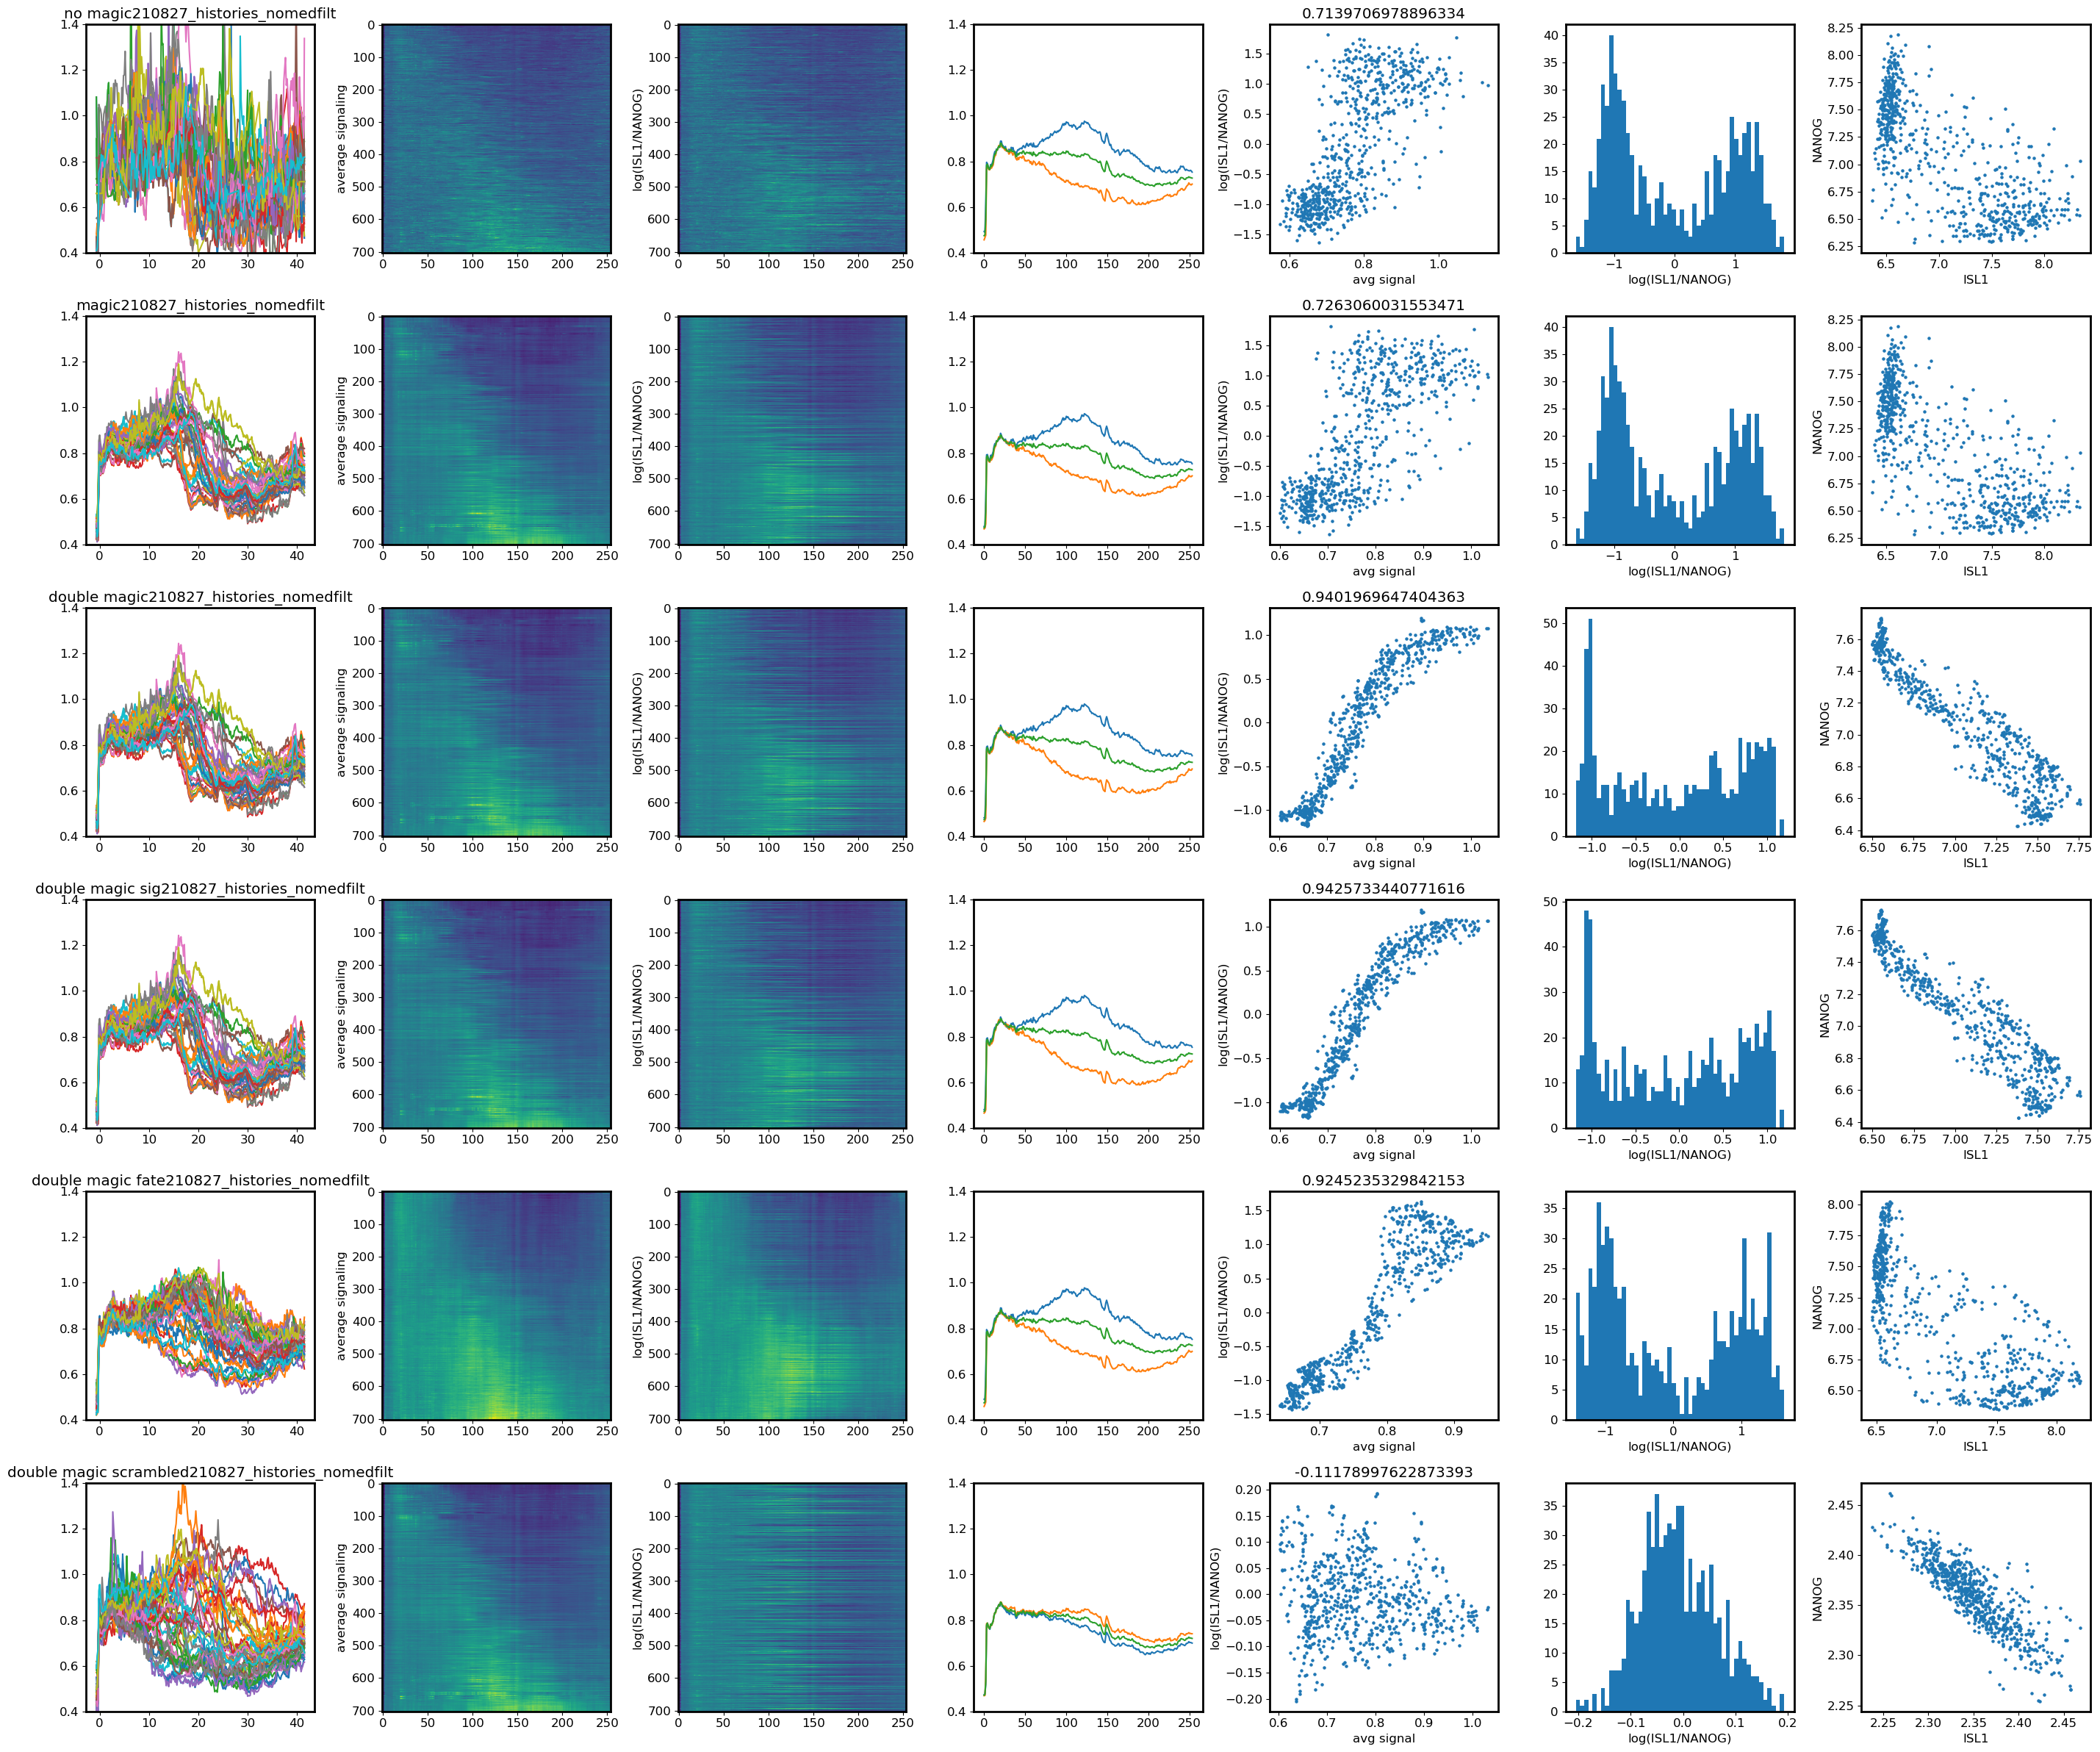

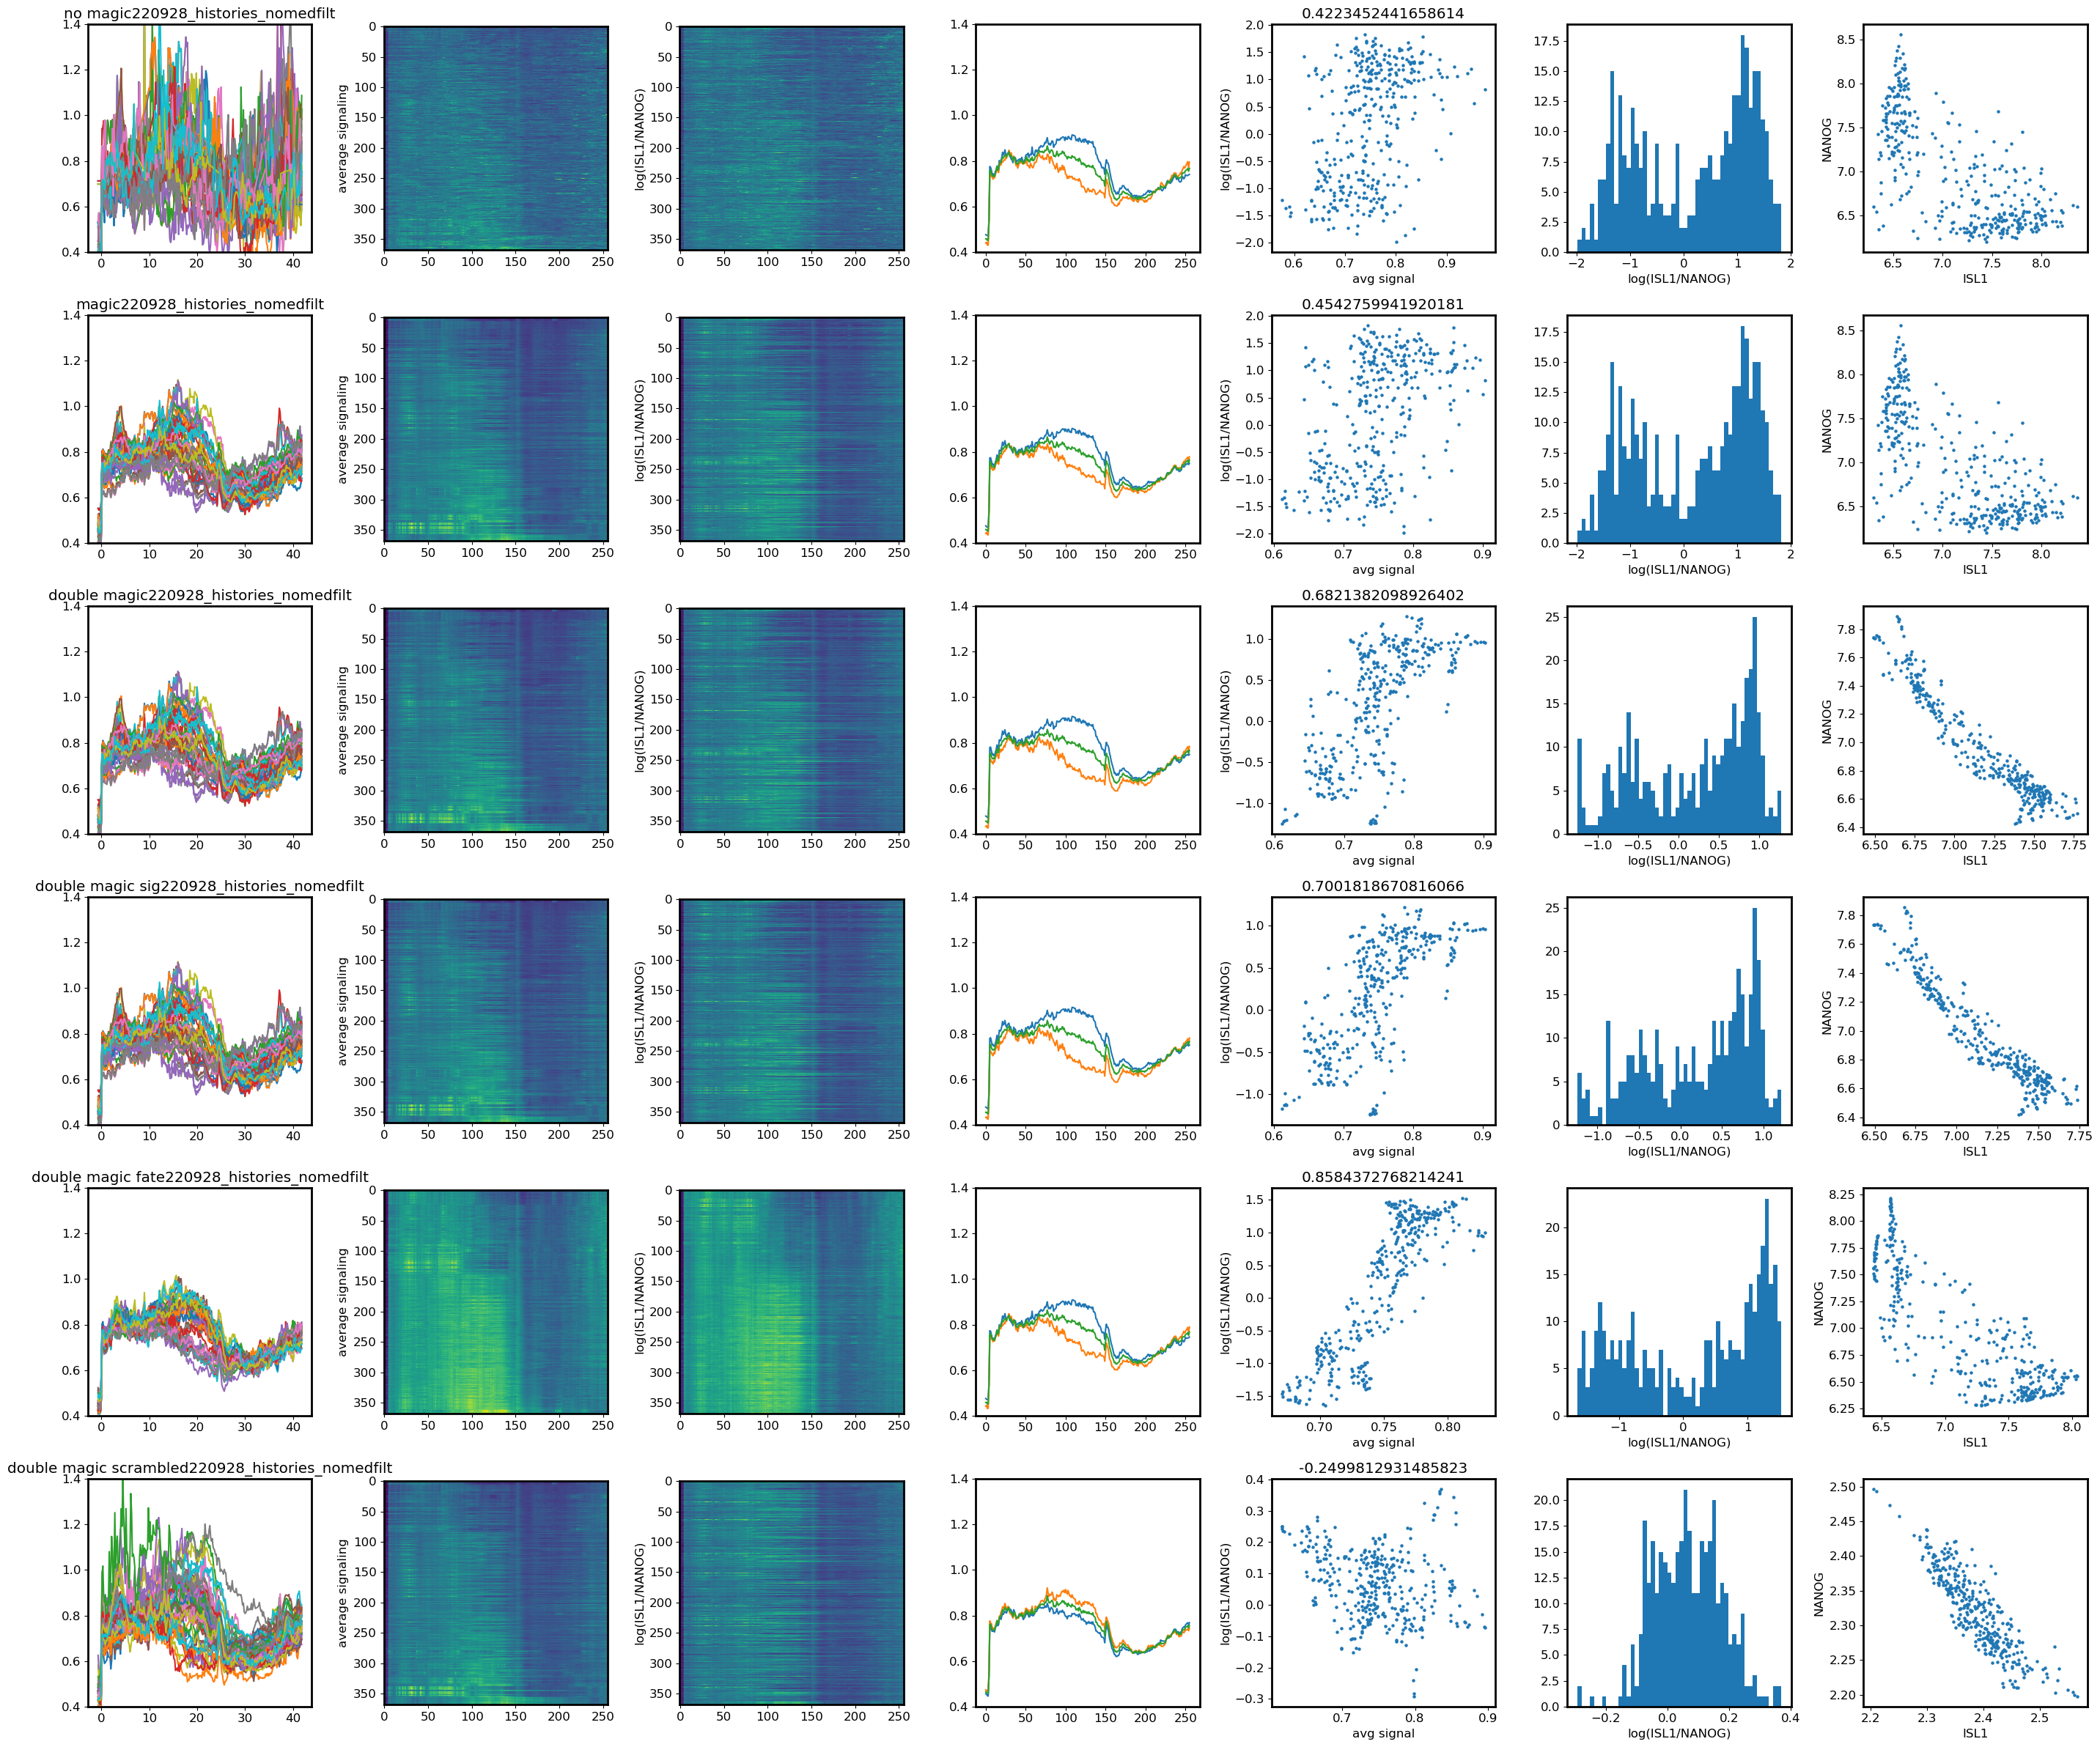

In [29]:
import magic

# magic parameters
knn = 3;
tmagic = 3;

# for plotting
plt.rcParams.update({'font.size':12})
def plotResults(axes, ri, chist_tmp, idx, lratio, title):
    
    n = 50; # number of histories to plot

    axes[ri,0].plot(t[d],chist_tmp[0:n,:].transpose());
    axes[ri,0].set_ylim([0.4, 1.4]);
    axes[ri,0].set_title(title + d);
    
    # all traces sorted
    X = np.sum(chist_tmp, axis=1)
    I = np.argsort(X)
    axes[ri,1].imshow(chist_tmp[I,:], aspect=aspect)
    axes[ri,1].set_ylabel('average signaling')

    # traces sorted by fate
    I = np.argsort(lr)
    axes[ri,2].imshow(chist_tmp[I,:], aspect=aspect)
    axes[ri,2].set_ylabel(logratiolabel)

    # mean of ISL1+ vs ISL1-
    meanhist = np.mean(chist_tmp, axis=0)
    posmean = np.mean(chist_tmp[lratio > rthresh[i],:],axis=0)
    negmean = np.mean(chist_tmp[lratio < rthresh[i],:],axis=0)
    meanhist = np.mean((posmean,negmean),axis=0) # a way to class balance the mean
    axes[ri,3].plot(posmean)
    axes[ri,3].plot(negmean)
    axes[ri,3].plot(meanhist)
    axes[ri,3].set_ylim([0.4, 1.4]);

    # scatter mean signal (i.e. integral normalized by time) and fate
    tsig = np.mean(chist_tmp, axis=1);
    axes[ri,4].scatter(tsig, lratio, s=5)
    C = np.corrcoef(tsig, lratio);
    axes[ri,4].set_title(str(C[0,1]));
    axes[ri,4].set_ylabel(logratiolabel)
    axes[ri,4].set_xlabel('avg signal')
    
    # fate histogram
    axes[ri,5].hist(lratio,bins=50);
    axes[ri,5].set_xlabel(logratiolabel);
    
    # scatter ISL1 v NANOG
    axes[ri,6].scatter(x,y, s=5)
    axes[ri,6].set_ylabel(channelLabels[d][yi]);
    axes[ri,6].set_xlabel(channelLabels[d][xi]);


# loop over datasets
for i,d in enumerate(dsetlabels):
 
    # SET CONDITION HERE (>0 means all)
    #--------------------------------------
    idx = conditionIdx[d]>0;
    
    # signaling histories for the selected dataset and conditions
    chist_tmp = chist[d][idx,:];

    # useful dimensions
    ntime = len(t[d]);
    aspect = chist_tmp.shape[1]/chist_tmp.shape[0];
    
    # figure axes
    Nrow=6; Ncol=7; 
    fig, axes = plt.subplots(Nrow,Ncol, figsize=(Ncol*4,Nrow*4))

    # DEFINE FATE MARKERS 
    #---------------------------------------
    # select channels for for fatemarkers (for 220928 involves selecting better of repeated stains)
    if d == '220928_histories_nomedfilt' :
        cidx = [1,2 , 3,  5,  6,  7,  9]; 
    else:
        fixedChannels = [str(f[d]['fixedChannels'][i][0])[2:-1] for i in range(0, len(f[d]['fixedChannels']))];
        cidx = np.array([i for i in range(0,len(fixedChannels)) if fixedChannels[i]!='DAPI' and fixedChannels[i]!='pSmad1']);

    # log transform, define x,y as ISL1, NANOG (indexing is offset by 1)
    fm = np.log(fateMarkers[d][idx,:])    
    fm = fm[:,cidx];
    x = fm[:,xi-1]; y = fm[:,yi-1];
    lr = x - y;
    
    # we compare a number of different ways of denoising, capitalized below    
    
    # NO MAGIC
    #--------------------------------------------------------------------------------------------------------------
    ri = 0;
    plotResults(axes, ri, chist_tmp, idx, lr, 'no magic')

    # MAGIC ON HISTORIES
    #--------------------------------------------------------------------------------------------------------------
    chist_magic = magic.MAGIC(knn=knn, t=tmagic, n_pca=10, decay=1).fit_transform(chist[d][idx,:])
    pd.DataFrame(chist_magic).to_csv(d + '_magic.csv')
    ri = 1;
    plotResults(axes, ri, chist_magic, idx, lr, 'magic')

    # MAGIC ON HISTORIES + FATE
    #--------------------------------------------------------------------------------------------------------------
    ri = 2;
    
    # relative weight of fate to histories
    scale = 1/3;
    histfate = np.column_stack((chist[d][idx,:], scale*fm))
    
    m = magic.MAGIC(knn=knn, t=tmagic, n_pca=10, decay=1).fit(histfate);
    histfate_magic = m.transform(histfate);
    chist_magic = histfate_magic[:,0:ntime];
    pd.DataFrame(chist_magic).to_csv(d + '_dmagic.csv')
    pd.DataFrame(histfate_magic[:,ntime:]).to_csv(d + '_fm_dmagic.csv');
    
    x = histfate_magic[:,ntime+xi-1]/scale; # -1 because we left out DAPI
    y = histfate_magic[:,ntime+yi-1]/scale;
    logratio_dmagic = x-y; 

    plotResults(axes, ri, chist_magic, idx, logratio_dmagic, 'double magic')
    
    # MAGIC ON HISTORIES, ALSO TRANSFORM FATE
    #--------------------------------------------------------------------------------------------------------------
    ri = 3;
    
    m = magic.MAGIC(knn=knn, t=tmagic, n_pca=10, decay=1).fit(chist[d][idx,:])
    chist_magic = m.transform(chist[d][idx,:])
    fate_magic = m.transform(fm)
    pd.DataFrame(chist_magic).to_csv(d + '_dmagic_hist.csv')
    pd.DataFrame(fate_magic).to_csv(d + '_fm_dmagic_hist.csv');

    x = fate_magic[:,xi-1] # -1 because we left out DAPI
    y = fate_magic[:,yi-1]
    logratio_dmagic_sig = x-y;#np.log((1+x)/(1+y));

    plotResults(axes, ri, chist_magic, idx, logratio_dmagic_sig, 'double magic sig')
        
    # MAGIC ON FATE, ALSO TRANSFORM HISTORIES
    #--------------------------------------------------------------------------------------------------------------
    ri = 4;
    
    m = magic.MAGIC(knn=knn, t=tmagic, n_pca=10, decay=1).fit(fm[idx,:])
    chist_magic = m.transform(chist[d][idx,:])
    fate_magic = m.transform(fm[idx,:])    
    pd.DataFrame(chist_magic).to_csv(d + '_dmagic_fate.csv')
    pd.DataFrame(fate_magic).to_csv(d + '_fm_dmagic_fate.csv');
    
    x = fate_magic[:,xi-1] # -1 because we left out DAPI
    y = fate_magic[:,yi-1]
    logratio_dmagic_fate = x-y;

    plotResults(axes, ri, chist_magic, idx, logratio_dmagic_fate, 'double magic fate')
    
    # MAGIC ON HISTORIES + FATE: RANDOMIZED HISTORY CONTROL
    #--------------------------------------------------------------------------------------------------------------
    ri = 5;
    
    hist_scramble = chist_tmp[np.random.permutation(sum(idx)),:];
    histfate_scramble = np.column_stack((hist_scramble, scale*fm));
    histfate_scramble_magic = magic.MAGIC(knn=knn, t=tmagic, n_pca=20, decay=1).fit_transform(histfate_scramble)

    chist_magic = histfate_scramble_magic[:,0:ntime];
    pd.DataFrame(chist_magic).to_csv(d + '_scramble_dmagic.csv')
    pd.DataFrame(histfate_scramble_magic[:,ntime:]).to_csv(d + '_fm_scramble_dmagic.csv');
    
    x = histfate_scramble_magic[:,ntime+xi-1] # -1 because we left out DAPI
    y = histfate_scramble_magic[:,ntime+yi-1]
    logratio_scramble_dmagic = x-y;

    plotResults(axes, ri, chist_magic, idx, logratio_scramble_dmagic, 'double magic scrambled')
    
    plt.tight_layout()